In [1]:
%pip install --quiet -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from models.hunt_data_loader import HuntDataLoader
from models.alzheimers_cure_2d import VAE

data_loader = HuntDataLoader()

## Split Data into Training and Test

In [3]:
training_pairs, test_pairs = data_loader.split_training_test_paths(seed=69)

Display the middle slice of the first training pair

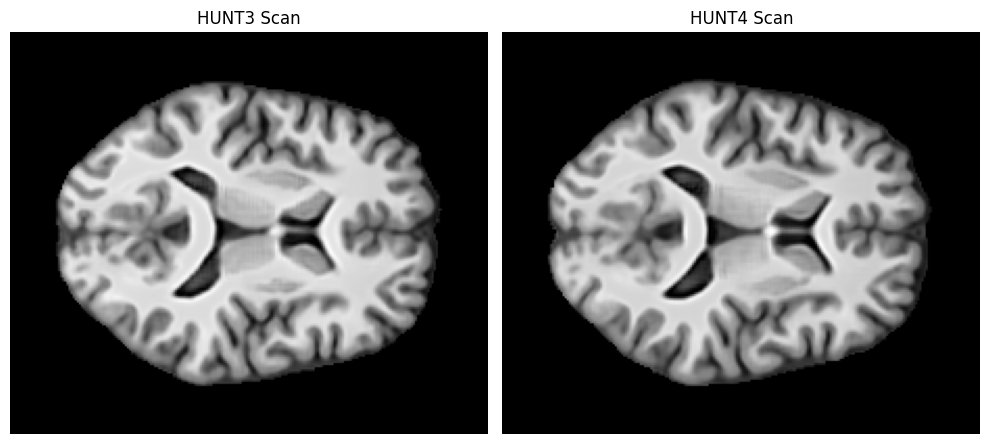

In [4]:
middle_h3 = data_loader.get_slice(training_pairs[0][0], index=90)
middle_h4 = data_loader.get_slice(training_pairs[0][1], index=90)

data_loader.display_slices(middle_h3, middle_h4)

## Train 2D-slice VAE Model

### Helper functions

In [5]:
def vae_loss(recon, target, mu, logvar):
    # Reconstruction: BCE because inputs are in [0,1]
    bce = nn.functional.binary_cross_entropy(recon, target, reduction='mean')
    # KL divergence
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    # Small KL weight for stability
    return bce + 1e-3 * kld, bce, kld


# --- Helper conversions ---
def to_torch_img(x, device):
    """
    x: numpy array or torch tensor with shape (192,224) or (1,192,224), values in [0,1]
    -> returns (1,1,192,224) float32 on device
    """
    if isinstance(x, np.ndarray):
        t = torch.from_numpy(x)
    else:
        t = x
    t = t.float()
    if t.ndim == 2:
        t = t.unsqueeze(0)  # (1,H,W)
    elif t.ndim == 3 and t.shape[0] != 1:
        # If it's (H,W,1), move channel first
        if t.shape[-1] == 1:
            t = t.permute(2,0,1)
    t = t.clamp(0, 1)
    t = t.unsqueeze(0)      # (1,1,H,W)
    return t.to(device)

def to_numpy_img(t):
    """
    t: torch tensor (1,1,H,W) or (1,H,W) or (H,W)
    -> numpy (H,W) in [0,1]
    """
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu()
    arr = t.squeeze().numpy() if isinstance(t, torch.Tensor) else np.array(t).squeeze()
    return np.clip(arr, 0.0, 1.0)

### Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = VAE(latent_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

cuda


In [7]:
model.train()
saved_snapshots = []  # We save snapshots every 10th pair for visualization
save_every = 50

for i in range(700):
    # Import all slices for the i'th training pair
    xs = data_loader.get_all_slices_as_tensor(training_pairs[i][0], crop_size=(192,224))[10:-10]  # (N, 192, 224)
    ys = data_loader.get_all_slices_as_tensor(training_pairs[i][1], crop_size=(192,224))[10:-10]  # (N, 192, 224)

    num = min(len(xs), len(ys)) # They should be equal, but just in case
    running_loss = running_bce = running_kld = 0.0

    for idx in range(num):
        x_slice = xs[idx]
        y_slice = ys[idx]

        x = to_torch_img(x_slice, device)  # (1,1,192,224)
        y = to_torch_img(y_slice, device)  # (1,1,192,224)

        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, bce, kld = vae_loss(recon, y, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item())
        running_bce  += float(bce.item())
        running_kld  += float(kld.item())

    denom = max(1, num)
    print(f"[Pair {i}] avg total: {running_loss/denom:.4f} | "
          f"recon: {running_bce/denom:.4f} | kld: {running_kld/denom:.6f}")

    # --- Every Xth pair, save a snapshot of reconstruction vs target ---
    if (i + 1) % save_every == 0 and num > 0:
        # pick a safe index to visualize
        idx_to_show = 90 if num > 90 else (num // 2)
        with torch.no_grad():
            x_show = to_torch_img(xs[idx_to_show], device)
            y_show = to_torch_img(ys[idx_to_show], device)
            recon_show, _, _ = model(x_show)

            xy_np   = to_numpy_img(y_show)       # target (H,W) in [0,1]
            recon_np = to_numpy_img(recon_show)   # recon  (H,W) in [0,1]

        saved_snapshots.append({"pair_idx": i, "xy": xy_np, "recon": recon_np})
        print(f"Saved snapshot for pair {i} at slice idx {idx_to_show}")

[Pair 0] avg total: 0.2278 | recon: 0.2137 | kld: 14.171317
[Pair 1] avg total: 0.1960 | recon: 0.1942 | kld: 1.825313
[Pair 2] avg total: 0.1959 | recon: 0.1941 | kld: 1.762637
[Pair 3] avg total: 0.2019 | recon: 0.1989 | kld: 3.085019
[Pair 4] avg total: 0.1968 | recon: 0.1941 | kld: 2.740639
[Pair 5] avg total: 0.1993 | recon: 0.1975 | kld: 1.754177
[Pair 6] avg total: 0.2008 | recon: 0.1994 | kld: 1.307456
[Pair 7] avg total: 0.1976 | recon: 0.1967 | kld: 0.898109
[Pair 8] avg total: 0.1960 | recon: 0.1950 | kld: 0.962137
[Pair 9] avg total: 0.1991 | recon: 0.1981 | kld: 0.928370
[Pair 10] avg total: 0.2082 | recon: 0.2072 | kld: 0.927049
[Pair 11] avg total: 0.1967 | recon: 0.1951 | kld: 1.521517
[Pair 12] avg total: 0.1957 | recon: 0.1946 | kld: 1.176397
[Pair 13] avg total: 0.1988 | recon: 0.1977 | kld: 1.060021
[Pair 14] avg total: 0.1982 | recon: 0.1973 | kld: 0.881439
[Pair 15] avg total: 0.1962 | recon: 0.1956 | kld: 0.601619
[Pair 16] avg total: 0.1996 | recon: 0.1989 | kld

IndexError: list index out of range

### Show results of Training

Displaying snapshot from pair 49


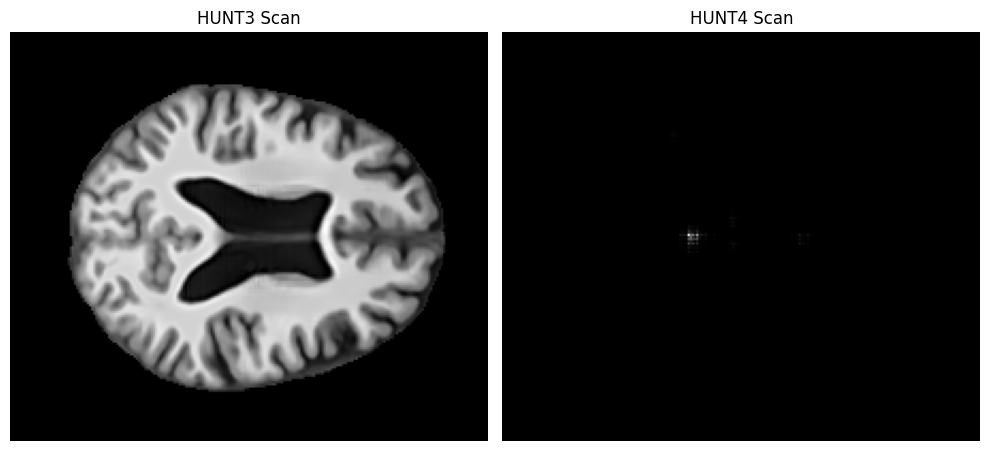

Displaying snapshot from pair 99


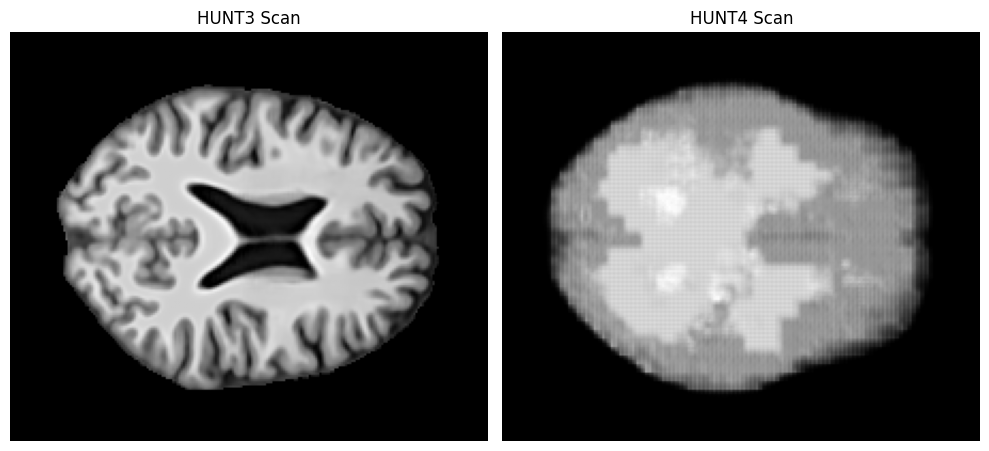

Displaying snapshot from pair 149


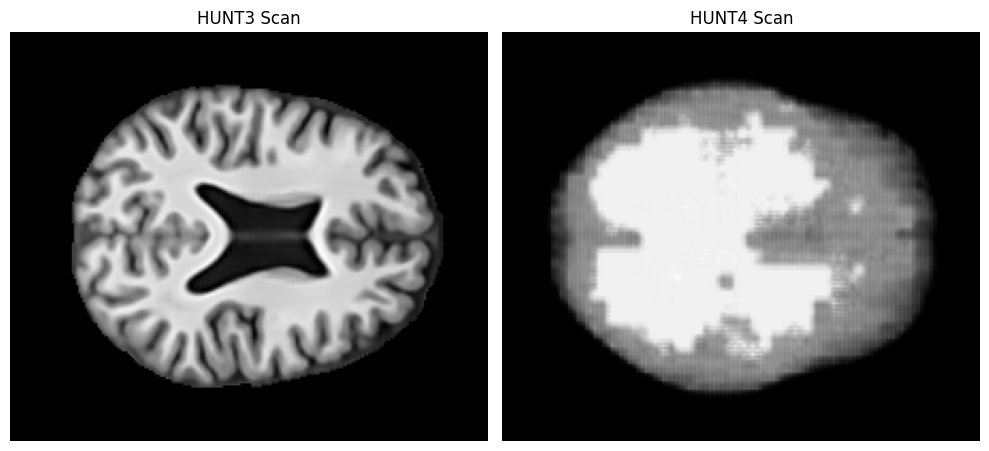

Displaying snapshot from pair 199


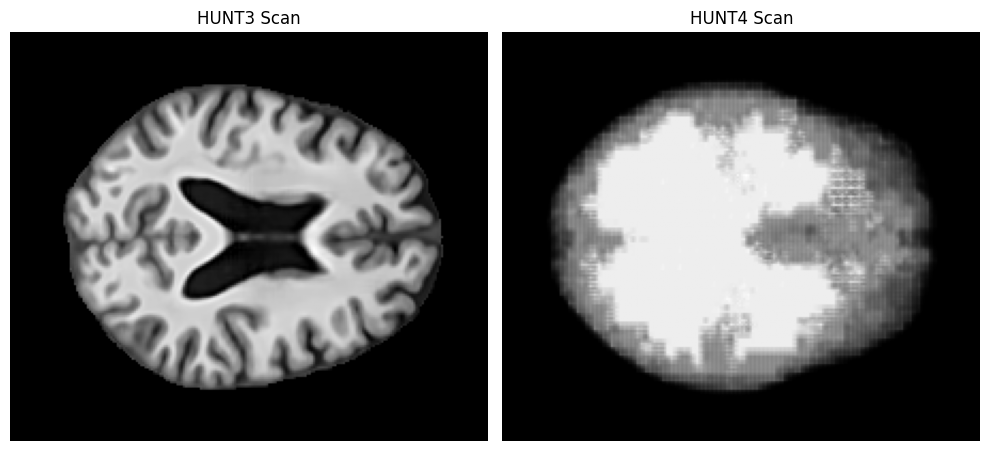

Displaying snapshot from pair 249


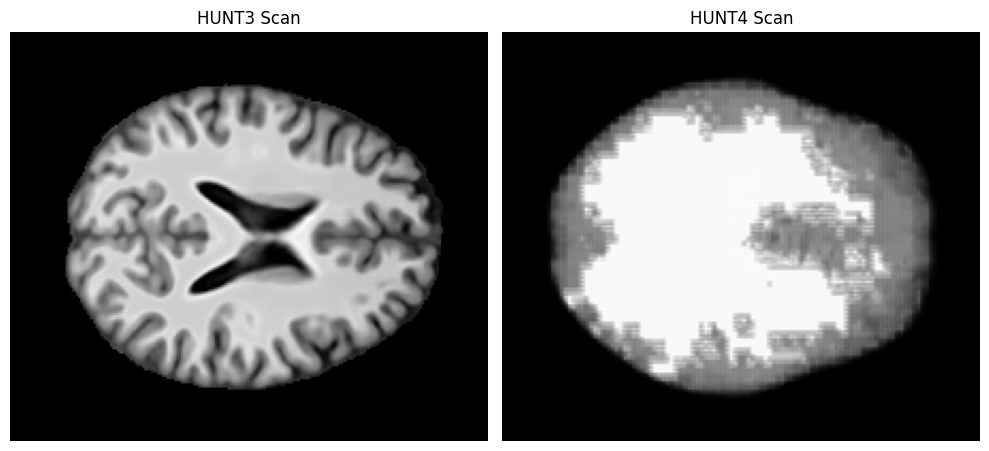

Displaying snapshot from pair 299


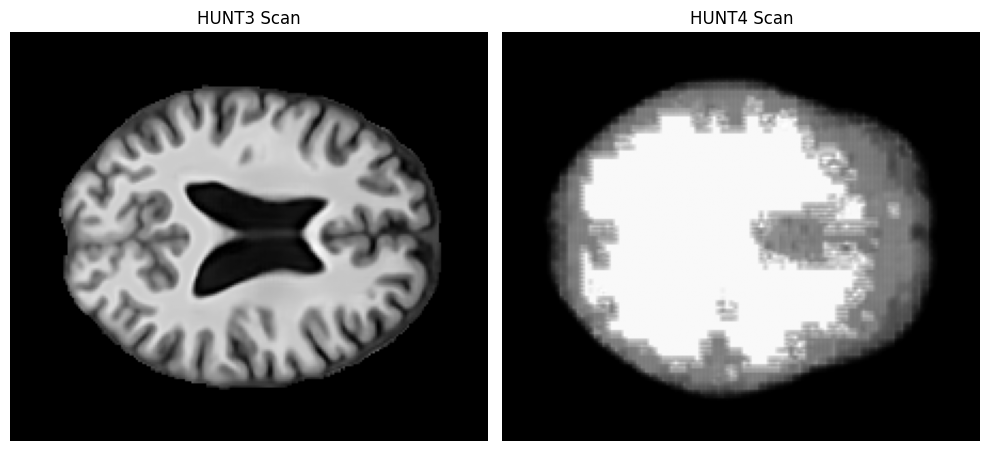

Displaying snapshot from pair 349


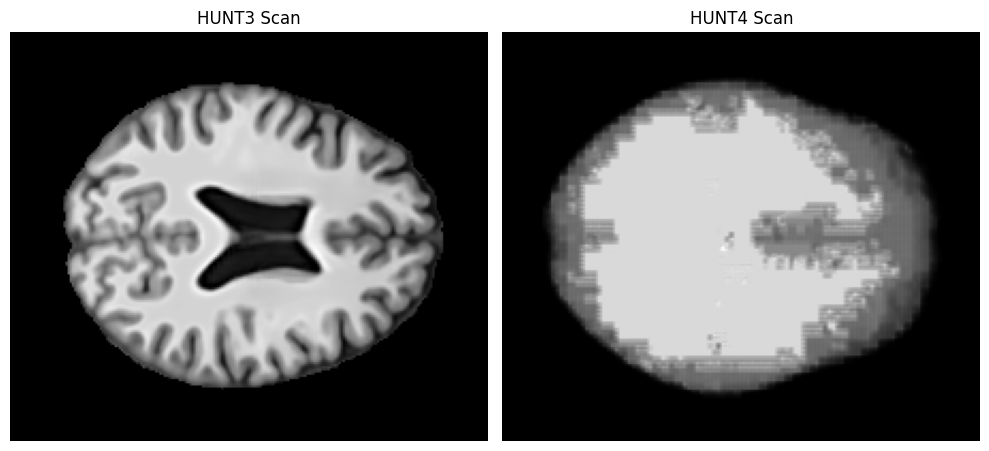

Displaying snapshot from pair 399


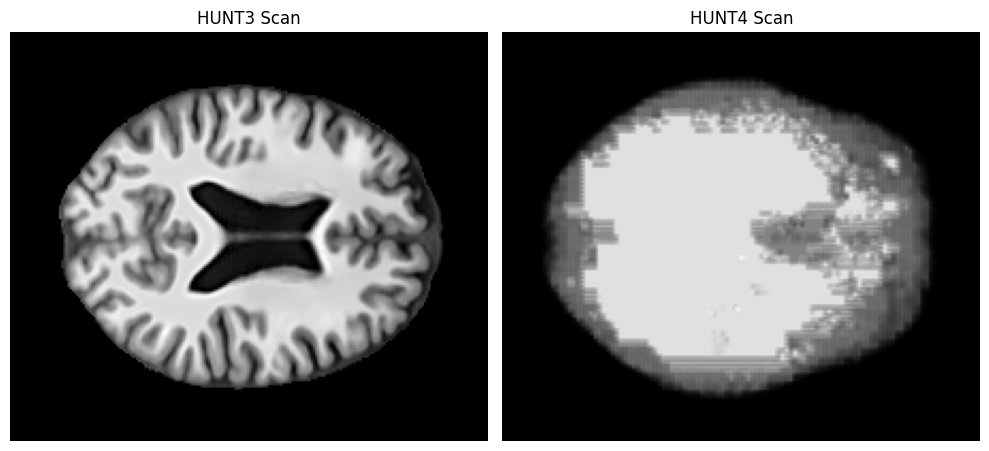

Displaying snapshot from pair 449


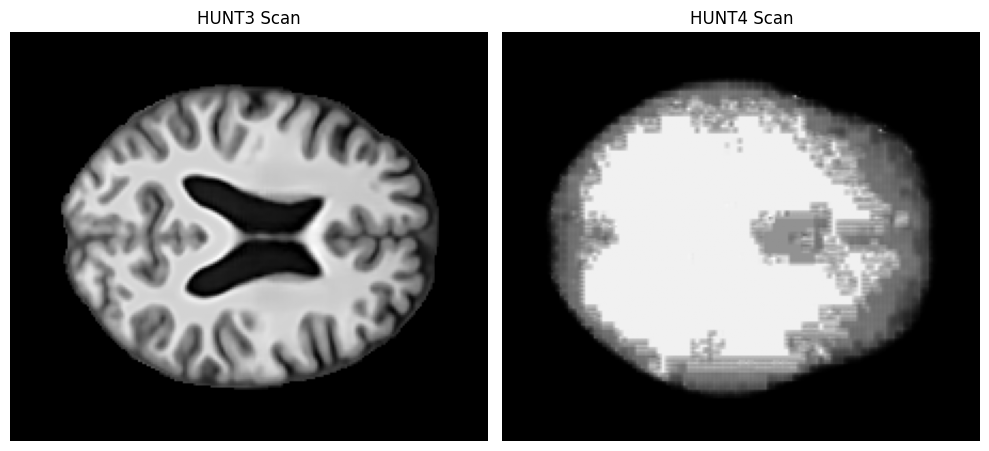

Displaying snapshot from pair 499


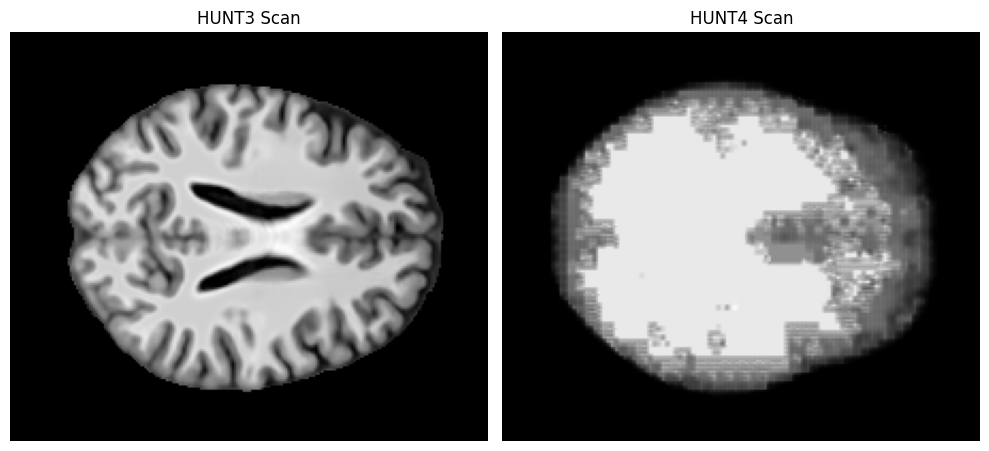

Displaying snapshot from pair 549


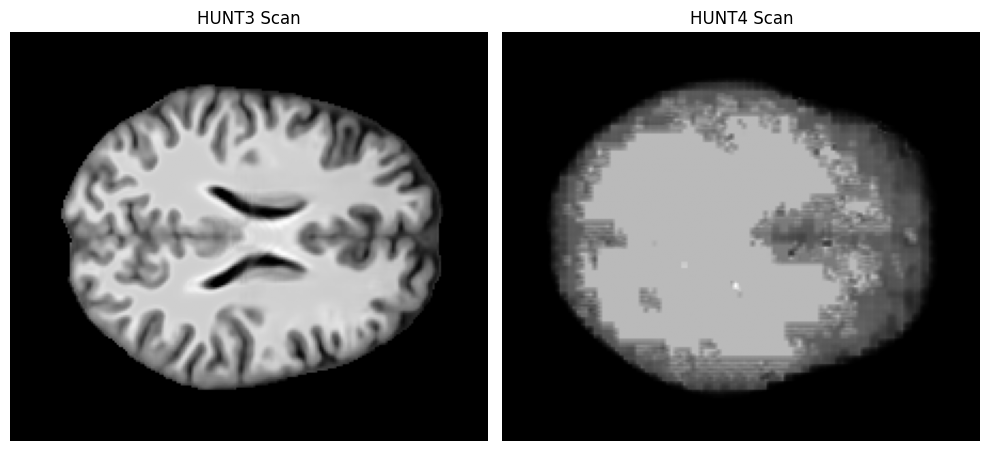

Displaying final test (pair 69, slice 90)


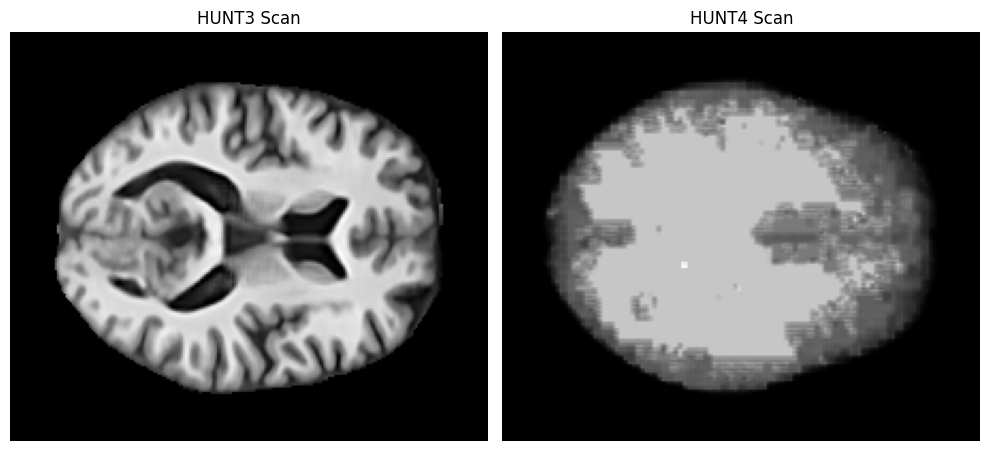

In [8]:
model.eval()
with torch.no_grad():
    xs = data_loader.get_all_slices_as_tensor(training_pairs[69][0], crop_size=(192,224))[90]
    xy = data_loader.get_all_slices_as_tensor(training_pairs[69][1], crop_size=(192,224))[90]

    x = to_torch_img(xs, device)
    recon, _, _ = model(x)

    recon_y = to_numpy_img(recon)  # (192,224)
    xy_np   = to_numpy_img(xy)     # (192,224)

# --- DISPLAY: all saved snapshots, then the final test slice ---
for snap in saved_snapshots:
    print(f"Displaying snapshot from pair {snap['pair_idx']}")
    data_loader.display_slices(snap["xy"], snap["recon"])

print("Displaying final test (pair 69, slice 90)")
data_loader.display_slices(xy_np, recon_y)